# 🩺 Breast Lesion Classification Using Explainable AI on the CBIS-DDSM Dataset 📊

Welcome to this project where we dive into breast cancer diagnosis using state-of-the-art AI! 🧠✨

The **CBIS-DDSM (Curated Breast Imaging Subset of Digital Database for Screening Mammography)** dataset is a publicly available, well-curated collection of mammography images, focused on breast lesion classification. It’s a cornerstone for researchers developing and testing machine learning models to improve breast cancer detection and diagnosis. 🎯

## What’s inside this dataset? 📦

* **Mammogram Images:** High-quality cropped images centered on lesions, including two major lesion types:

  * **Masses**: Solid lumps that can be benign or malignant.
  * **Calcifications**: Tiny calcium deposits, often early signs of breast cancer.

* **Detailed Metadata:** Including pathology labels (Benign vs Malignant), lesion characteristics (shape, margin), and patient information — crucial for both supervised learning and explainability analysis. 📝

* **Train & Test Splits:** The dataset is neatly divided for proper model training and unbiased testing, allowing you to build robust predictive models.

## Why use CBIS-DDSM? 🤔

* **Clinical Relevance:** The dataset reflects real-world screening mammography, making your model outcomes clinically meaningful.
* **Rich Annotations:** Multiple lesion characteristics and biopsy-confirmed labels ensure high-quality ground truth.
* **Challenge & Opportunity:** Variations in image quality, lesion appearance, and class imbalance offer a realistic challenge for AI models — perfect for showcasing the power of explainable AI techniques.

## Project Goal 🎯

Using this dataset, we aim to build a convolutional neural network (CNN) model to classify breast lesions into benign or malignant categories. Alongside, we integrate explainability methods to make the AI’s decision process transparent and trustworthy for clinical use.

Let’s embark on this journey to combine medical imaging, AI, and explainability to contribute towards better breast cancer diagnosis! 💪🔬


In [11]:
# STEP 0: Install kagglehub if not already installed
!pip install -q kagglehub

# STEP 1: Upload your Kaggle API key
from google.colab import files
print("📁 Please upload your kaggle.json file...")
uploaded = files.upload()

# STEP 2: Configure Kaggle credentials
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# STEP 3: Download the CBIS-DDSM dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")
print("✅ Download complete. Dataset saved to:", dataset_path)

📁 Please upload your kaggle.json file...


Saving kaggle.json to kaggle (1).json
✅ Download complete. Dataset saved to: /kaggle/input/cbis-ddsm-breast-cancer-image-dataset


# 📁 Exploring the Dataset Folder Structure 🗂️

Before diving into the data, it’s important to understand how the dataset is organized on disk. This helps us efficiently access and process images and metadata.

* **Root Folder:** The main dataset directory contains several subfolders including:

  * `jpeg/` — This folder contains all the mammography images in JPEG format, organized into subfolders by patient/study IDs.
  * `csv/` — This folder stores metadata CSV files describing the images, lesions, patient info, and DICOM details.

By listing contents inside these folders, we get a glimpse of:

* The **jpeg/** folder contains many patient folders, each holding cropped mammogram images relevant for lesion classification.
* The **csv/** folder holds key CSV files like mass and calcification descriptions, and DICOM metadata, which we will use to link image files to lesion labels.

Understanding this structure ensures smooth data loading and management throughout our project. Next, we’ll use this knowledge to load and merge the image data with lesion metadata for modeling.


In [13]:
print(os.listdir(dataset_path))

['jpeg', 'csv']


In [14]:
jpeg_path = os.path.join(dataset_path, 'jpeg')
print("JPEG folder contents:", os.listdir(jpeg_path)[:10])

JPEG folder contents: ['1.3.6.1.4.1.9590.100.1.2.426013102412536473840491086280519425818', '1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780', '1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420', '1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925', '1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478', '1.3.6.1.4.1.9590.100.1.2.282352693311213476433671021062261222228', '1.3.6.1.4.1.9590.100.1.2.246955628010861739125873409552788690641', '1.3.6.1.4.1.9590.100.1.2.292218970012537041238753511811549815964', '1.3.6.1.4.1.9590.100.1.2.187342081210540130009911822423105065839', '1.3.6.1.4.1.9590.100.1.2.156462442713483525908710752592316394215']


In [15]:
csv_path = os.path.join(dataset_path, 'csv')
print("CSV folder contents:", os.listdir(csv_path))

CSV folder contents: ['dicom_info.csv', 'mass_case_description_train_set.csv', 'calc_case_description_train_set.csv', 'meta.csv', 'calc_case_description_test_set.csv', 'mass_case_description_test_set.csv']


In [16]:
sample_folder = os.listdir(jpeg_path)[0]
sample_folder_path = os.path.join(jpeg_path, sample_folder)
print(f"Sample JPEG folder name: {sample_folder}")
print("Files in this folder:", os.listdir(sample_folder_path))

Sample JPEG folder name: 1.3.6.1.4.1.9590.100.1.2.426013102412536473840491086280519425818
Files in this folder: ['1-223.jpg']


# 🔍 Exploratory Data Analysis (EDA): Sample Image Visualization 📸

To better understand the dataset, it’s essential to visually inspect some sample mammogram images. Here, we load a sample image from one of the patient folders and display it using matplotlib.

This step helps us:

* Verify image quality and format
* Get a feel for the visual characteristics of breast lesions
* Confirm the correct loading of images before training our model

Visual inspection is a crucial part of the data exploration process, especially in medical imaging tasks like breast lesion classification.


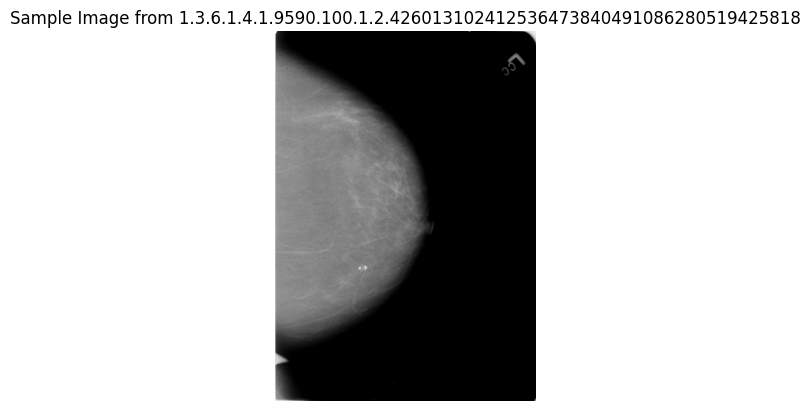

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

sample_image_path = os.path.join(sample_folder_path, os.listdir(sample_folder_path)[0])
img = Image.open(sample_image_path)

plt.imshow(img, cmap='gray')
plt.title(f"Sample Image from {sample_folder}")
plt.axis('off')
plt.show()


## Step 1: Set Dataset Path 🗂️

We begin by defining the path to the CBIS-DDSM dataset. This is the root folder containing the image files (JPEGs) and the associated CSV metadata files.

---

## Step 2: Load and Merge Metadata CSVs 📊

* We attempt to load pre-processed CSV files with corrected image paths to speed up the workflow.
* If those are not found, we:

  * Load the original train/test case description CSVs for masses.
  * Load the DICOM info CSV that contains detailed image metadata.
  * Extract the unique series IDs (`series_uid`) from image file paths.
  * Filter the DICOM info to only keep cropped images.
  * Dynamically find the corresponding JPEG image file for each series.
  * Merge this corrected image path info back into the mass case description data for both train and test sets.
* Finally, the corrected data is saved for future quick loading.

---

## Step 3: Standardize Column Names ✨

To maintain consistency and simplify coding, we clean the dataframe columns by:

* Converting to lowercase
* Replacing spaces with underscores
* Stripping any leading or trailing whitespace

This standardization helps avoid bugs related to inconsistent column naming.

---

## Step 4: Add Binary Labels & Combine Train/Test Sets 🎯

* We create a new binary label column indicating if a lesion is `Benign` or `Malignant`, based on the pathology description.
* Add a `split` column to mark the origin of each sample (`train` or `test`).
* Combine both datasets into a single dataframe for easier analysis and preprocessing.

---

## Step 5: Analyze Image Sizes 🖼️📏

* To understand the variability in image dimensions, we open each cropped image and record its width and height.
* We summarize these image sizes to help plan preprocessing steps like resizing and augmentation.
* This insight is critical because CNNs typically require input images of a fixed size.

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# -----------------------------
# 1. Dataset path
# -----------------------------
#dataset_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset'  # change if needed

# -----------------------------
# 2. Load or rebuild merged CSVs with fixed paths
# -----------------------------
try:
    df_merged = pd.read_csv('mass_train_corrected.csv')
    df_test_merged = pd.read_csv('mass_test_corrected.csv')
except FileNotFoundError:
    csv_path = os.path.join(dataset_path, 'csv')
    jpeg_path = os.path.join(dataset_path, 'jpeg')

    df_mass_train = pd.read_csv(os.path.join(csv_path, 'mass_case_description_train_set.csv'))
    df_mass_test = pd.read_csv(os.path.join(csv_path, 'mass_case_description_test_set.csv'))
    df_dicom = pd.read_csv(os.path.join(csv_path, 'dicom_info.csv'))

    # Extract series_uid from path
    df_mass_train['series_uid'] = df_mass_train['cropped image file path'].apply(
        lambda x: x.split('/')[-2] if pd.notnull(x) else None
    )
    df_mass_test['series_uid'] = df_mass_test['cropped image file path'].apply(
        lambda x: x.split('/')[-2] if pd.notnull(x) else None
    )

    # Keep only cropped images in dicom_info
    df_dicom_cropped = df_dicom[df_dicom['SeriesDescription'] == 'cropped images'].copy()

    # Function to get cropped jpeg path
    def get_cropped_jpeg(uid, base_path):
        folder = os.path.join(base_path, 'jpeg', uid)
        if not os.path.exists(folder):
            return None
        files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
        for f in files:
            if f.startswith('2-'):
                return os.path.join('jpeg', uid, f)
        return os.path.join('jpeg', uid, files[0]) if files else None

    df_dicom_cropped['corrected_file_path'] = df_dicom_cropped['SeriesInstanceUID'].apply(
        lambda x: get_cropped_jpeg(x, dataset_path)
    )

    # Merge with train and test
    def merge_with_paths(df_mass):
        df = df_mass.merge(
            df_dicom_cropped[['SeriesInstanceUID', 'corrected_file_path']],
            left_on='series_uid',
            right_on='SeriesInstanceUID',
            how='left'
        )
        df['cropped_image_path'] = df['corrected_file_path'].apply(
            lambda x: os.path.join(dataset_path, x) if pd.notnull(x) else None
        )
        return df

    df_merged = merge_with_paths(df_mass_train)
    df_test_merged = merge_with_paths(df_mass_test)

    # Save fixed CSVs
    df_merged.to_csv('mass_train_corrected.csv', index=False)
    df_test_merged.to_csv('mass_test_corrected.csv', index=False)

# -----------------------------
# 3. Standardize column names (fix 'mass shape' issue)
# -----------------------------
def standardize_columns(df):
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

df_merged = standardize_columns(df_merged)
df_test_merged = standardize_columns(df_test_merged)

# -----------------------------
# 4. Add binary label & combine train/test
# -----------------------------
df_train = df_merged.copy()
df_train['split'] = 'train'
df_train['binary_label'] = df_train['pathology'].apply(lambda x: 'Benign' if 'BENIGN' in x else 'Malignant')

df_test = df_test_merged.copy()
df_test['split'] = 'test'
df_test['binary_label'] = df_test['pathology'].apply(lambda x: 'Benign' if 'BENIGN' in x else 'Malignant')

df_all = pd.concat([df_train, df_test], ignore_index=True)

# -----------------------------
# 5. Image size check (train + test together, no repetition)
# -----------------------------
image_sizes = []
for path in df_all['cropped_image_path']:
    try:
        with Image.open(path) as img:
            image_sizes.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error reading {path}: {e}")

sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
print("\n📏 Image Size Summary:")
print(sizes_df.describe())


📏 Image Size Summary:
             Width       Height
count  1696.000000  1696.000000
mean   2117.692807  3389.353774
std    1511.915929  2558.545847
min     137.000000   168.000000
25%     388.000000   385.000000
50%    2686.000000  4648.000000
75%    3496.000000  5704.000000
max    5431.000000  6931.000000


## Dataset and DataLoader Setup for Breast Lesion Classification 🩺🖥️

### 1. Define a Custom PyTorch Dataset Class

* **`BreastLesionDataset`** inherits from `torch.utils.data.Dataset` to load and preprocess images and labels on the fly.

* In the `__init__` method:

  * We pass in a dataframe containing metadata and image paths.
  * Create binary labels: `0` for benign lesions, `1` for malignant.
  * Filter out rows where the image file does not exist to avoid errors during training.
  * Print the final dataset size after filtering to track how many valid samples we have.

* The `__len__` method returns the total number of samples.

* The `__getitem__` method:

  * Reads the image from disk in grayscale mode using OpenCV.
  * Converts the grayscale image to 3-channel RGB (required by many CNN architectures).
  * Retrieves the corresponding label.
  * Applies any image transformations (augmentation, resizing, normalization) if provided.
  * Returns the processed image and its label as a tuple.

---

### 2. Define Image Transformations (Data Augmentation & Preprocessing)

* Use `torchvision.transforms.Compose` to chain multiple transformations:

  * Convert the OpenCV numpy image to a PIL Image.
  * Resize all images to 224x224 pixels to match input size expected by most pretrained CNNs.
  * Apply random horizontal flips as augmentation to increase dataset variability.
  * Convert the image to a PyTorch tensor.
  * Normalize image pixels using ImageNet mean and standard deviation for better convergence.

---

### 3. Instantiate Train and Test Datasets

* Create `train_dataset` by passing the merged training dataframe and the transformation pipeline.
* Create `test_dataset` from the test dataframe without augmentation (only raw images).
* Print the number of samples in train and test sets to confirm dataset sizes.

---

### 4. Setup DataLoaders for Batch Processing

* Wrap datasets in PyTorch `DataLoader`s for efficient batching and shuffling:

  * `train_loader` uses a batch size of 32 and shuffles the data for training randomness.
  * `test_loader` uses batch size 32 without shuffling to keep evaluation consistent.

---

This setup ensures efficient data loading, preprocessing, and augmentation while preparing your data for training and evaluation of your CNN model.


In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np

class BreastLesionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        # Binary labels: BENIGN/BENIGN_WITHOUT_CALLBACK = 0, MALIGNANT = 1
        self.df['label'] = self.df['pathology'].apply(lambda x: 0 if 'BENIGN' in x else 1)
        # Filter valid paths
        self.df = self.df[self.df['cropped_image_path'].apply(lambda x: os.path.isfile(x) if pd.notnull(x) else False)].reset_index(drop=True)
        print(f"Dataset size after filtering: {len(self.df)}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['cropped_image_path'].iloc[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # To 3 channels
        label = self.df['label'].iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
])

# Train dataset (already confirmed: 1318 samples)
train_dataset = BreastLesionDataset(df_merged, transform=transform)
test_dataset = BreastLesionDataset(df_test_merged, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Dataset size after filtering: 1318
Dataset size after filtering: 378
Train samples: 1318, Test samples: 378


## 📊 Dataset Overview Summary

* **Total Samples:** 1,696

  * Training samples: 1,318
  * Testing samples: 378

* **Missing Data:**

  * `mass_shape`: 4 missing values
  * `mass_margins`: 60 missing values

* **Duplicates:** None found — dataset is clean!

* **Unique Patients:** 892 unique patients represented in the dataset

---

This overview helps us understand the dataset size, the presence of any missing information to handle, and patient diversity for robust model training.


In [20]:
# 1. Dataset Overview (already shared, but summarize key points)
print("Dataset Overview:")
print(f"- Shape: {df_all.shape[0]} samples (Train: {len(df_train)}, Test: {len(df_test)})")
print(f"- Missing Values: mass shape ({df_all['mass_shape'].isnull().sum()}), mass margins ({df_all['mass_margins'].isnull().sum()})")
print(f"- Duplicates: {df_all.duplicated().sum()}")
print(f"- Unique Patients: {df_all['patient_id'].nunique()}")

Dataset Overview:
- Shape: 1696 samples (Train: 1318, Test: 378)
- Missing Values: mass shape (4), mass margins (60)
- Duplicates: 0
- Unique Patients: 892


## 🏷️ Label Distribution Analysis

This section explores the distribution of the binary labels (`Benign` vs `Malignant`) across the entire dataset and separately for training and testing splits.

### Visualizations:

* **Left plot:** Overall count of benign vs malignant samples in the entire dataset.
* **Right plot:** Count of benign vs malignant samples broken down by train and test sets.

### Observations:

* The dataset is **slightly imbalanced**, with a higher proportion of **Benign (≈54%)** cases overall.
* The training set is more balanced, with about **52% Benign** and **48% Malignant**.
* The test set has a stronger skew towards Benign cases (**≈61% Benign**), which should be considered during model evaluation.

### Proportions Summary:

| Dataset Split | Benign Proportion | Malignant Proportion |
| ------------- | ----------------- | -------------------- |
| **Overall**   | 53.8%             | 46.2%                |
| **Train**     | 51.7%             | 48.3%                |
| **Test**      | 61.1%             | 38.9%                |

### Implications:

* Although the class imbalance is mild, using **class weighting** or **balanced sampling** during model training can improve performance on the minority class.
* Pay special attention to the test set’s bias toward Benign cases when interpreting results to avoid overly optimistic performance metrics.


📊 Label Distribution


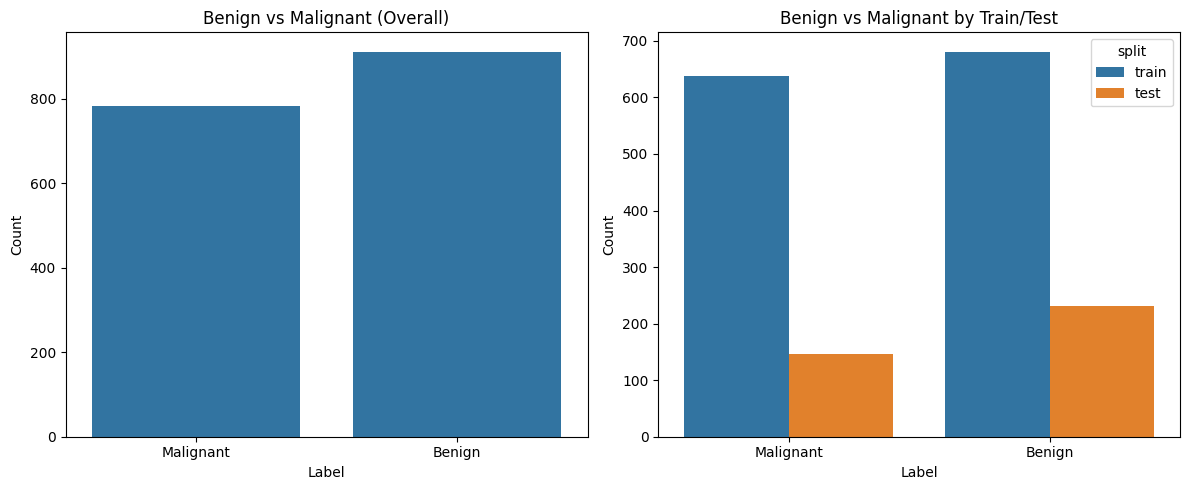


Proportions:
Overall:
 binary_label
Benign       0.537736
Malignant    0.462264
Name: proportion, dtype: float64
Train:
 binary_label
Benign       0.516692
Malignant    0.483308
Name: proportion, dtype: float64
Test:
 binary_label
Benign       0.611111
Malignant    0.388889
Name: proportion, dtype: float64


In [21]:
# 2. Label Distribution
print("\n📊 Label Distribution")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='binary_label', data=df_all, ax=axes[0])
axes[0].set_title('Benign vs Malignant (Overall)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
sns.countplot(x='binary_label', hue='split', data=df_all, ax=axes[1])
axes[1].set_title('Benign vs Malignant by Train/Test')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

print("\nProportions:")
print("Overall:\n", df_all['binary_label'].value_counts(normalize=True))
print("Train:\n", df_train['binary_label'].value_counts(normalize=True))
print("Test:\n", df_test['binary_label'].value_counts(normalize=True))

## 🔍 Feature Distributions & Their Relationship with Cancer Type

This section visualizes key categorical features in the dataset, showing how they relate to the binary cancer labels (`Benign` vs `Malignant`).

### Visualized Features:

1. **Breast Density:**
   Represents the density of breast tissue, which can affect mammogram readability and cancer detection.

   * Variation in breast density could correlate with cancer presence.

2. **Mass Shape:**
   Describes the shape of detected masses in the breast tissue (e.g., round, irregular).

   * Certain shapes may be more indicative of malignancy.

3. **Mass Margins:**
   Describes the edges or margins of a mass (e.g., circumscribed, indistinct).

   * Margin characteristics are important diagnostic clues.

4. **Subtlety:**
   Indicates how subtle or obvious the mass is on the mammogram images.

   * Less subtle masses might be easier to detect and diagnose.

### Insights from the Plots:

* **Breast Density:** Different densities show varying proportions of benign and malignant cases, suggesting density impacts cancer detection and risk.
* **Mass Shape & Margins:** Certain shapes and margin types tend to be more associated with malignant or benign classes, supporting their diagnostic importance.
* **Subtlety:** The distribution suggests subtle masses are present across both benign and malignant classes but may differ in frequency.

### Why This Matters:

Understanding these feature distributions helps:

* Inform feature selection and engineering for predictive modeling.
* Provide clinical context to model predictions.
* Guide explainability efforts by linking features to outcomes.


🔍 Key Feature Patterns


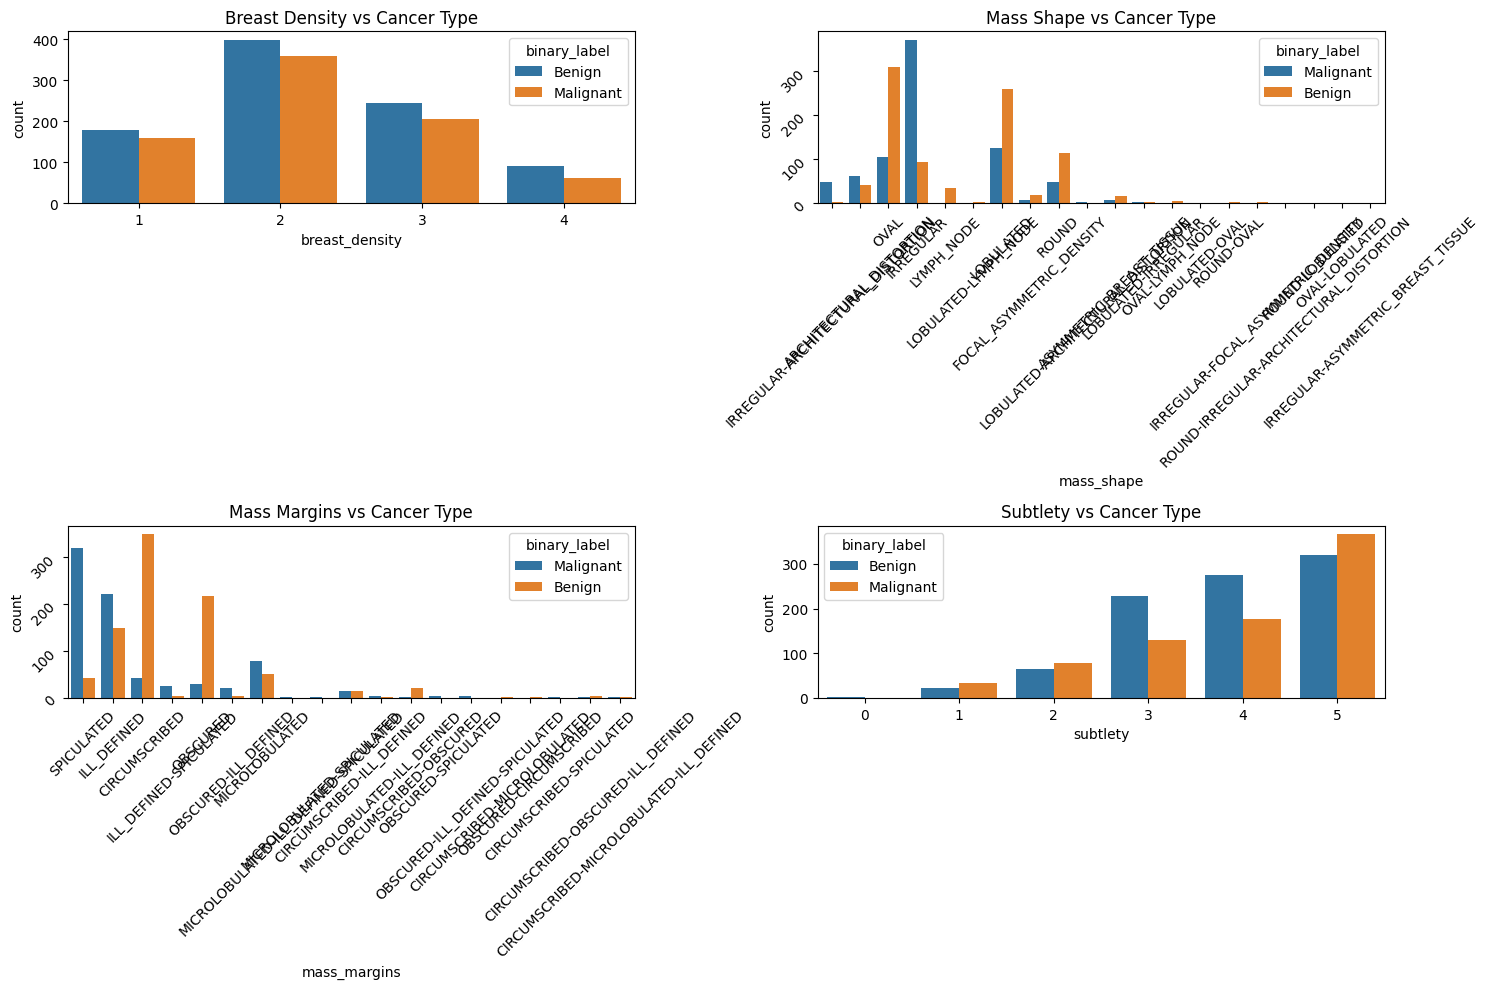

In [22]:
# 3. Feature Distributions
print("\n🔍 Key Feature Patterns")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(x='breast_density', hue='binary_label', data=df_all, ax=axes[0,0])
axes[0,0].set_title('Breast Density vs Cancer Type')
sns.countplot(x='mass_shape', hue='binary_label', data=df_all, ax=axes[0,1])
axes[0,1].set_title('Mass Shape vs Cancer Type')
axes[0,1].tick_params(labelrotation=45)
sns.countplot(x='mass_margins', hue='binary_label', data=df_all, ax=axes[1,0])
axes[1,0].set_title('Mass Margins vs Cancer Type')
axes[1,0].tick_params(labelrotation=45)
sns.countplot(x='subtlety', hue='binary_label', data=df_all, ax=axes[1,1])
axes[1,1].set_title('Subtlety vs Cancer Type')
plt.tight_layout()
plt.show()

## 📊 Cross-Tab Analysis: Mass Shape and Mass Margins vs Cancer Label

We use **cross-tabulations** to understand the relationship between categorical features (`mass_shape`, `mass_margins`) and the binary cancer label (`Benign` vs `Malignant`). The tables show **proportions of benign and malignant cases within each category**, normalized by row.

### Mass Shape vs Label

* Certain mass shapes like **IRREGULAR**, **ARCHITECTURAL\_DISTORTION**, and combinations with irregular shapes show a **higher proportion of malignant cases** (up to \~94% for some).
* Shapes like **ASYMMETRIC\_BREAST\_TISSUE**, **FOCAL\_ASYMMETRIC\_DENSITY**, **LOBULATED**, and **OVAL** tend to have a **higher proportion of benign cases**.
* This suggests that the shape of a mass is a strong indicator for malignancy prediction.

### Mass Margins vs Label

* Margins such as **SPICULATED**, **ILL\_DEFINED**, and their combinations have a **high proportion of malignant cases** (often >80%).
* Conversely, **CIRCUMSCRIBED** and **OBSCURED** margins mostly correspond to **benign masses**.
* Margin characteristics provide critical diagnostic cues, and their strong association with malignancy underlines their importance in classification models.

### Summary

These cross-tabs highlight how specific morphological features correlate strongly with cancer status, validating their use as predictive features. Features with strong class imbalances should be carefully modeled and potentially used to guide explainable AI methods.

In [23]:
# Cross-tabs
print("\nMass Shape vs Label (Proportions):\n", pd.crosstab(df_all['mass_shape'], df_all['binary_label'], normalize='index'))
print("\nMass Margins vs Label (Proportions):\n", pd.crosstab(df_all['mass_margins'], df_all['binary_label'], normalize='index'))


Mass Shape vs Label (Proportions):
 binary_label                                Benign  Malignant
mass_shape                                                   
ARCHITECTURAL_DISTORTION                  0.407767   0.592233
ASYMMETRIC_BREAST_TISSUE                  0.680000   0.320000
FOCAL_ASYMMETRIC_DENSITY                  0.720000   0.280000
IRREGULAR                                 0.200431   0.799569
IRREGULAR-ARCHITECTURAL_DISTORTION        0.057692   0.942308
IRREGULAR-ASYMMETRIC_BREAST_TISSUE        1.000000   0.000000
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY        1.000000   0.000000
LOBULATED                                 0.671875   0.328125
LOBULATED-ARCHITECTURAL_DISTORTION        0.000000   1.000000
LOBULATED-IRREGULAR                       0.333333   0.666667
LOBULATED-LYMPH_NODE                      1.000000   0.000000
LOBULATED-OVAL                            1.000000   0.000000
LYMPH_NODE                                1.000000   0.000000
OVAL                             

## 📸 Image Data Exploration: Shapes and Pixel Intensities

We analyzed a **random sample of 20 images** from both the train and test datasets to gain insights into their spatial dimensions and pixel intensity distributions.

### What this code does:

* Loads grayscale images using OpenCV.
* Records image shapes (height × width) to capture size variability.
* Resizes large images to 100×100 pixels for efficient pixel intensity sampling.
* Collects pixel intensities (grayscale values) from sampled images.
* Plots histograms of pixel intensities for train and test sets separately.

### Results:

* **Image Sizes:**

  * Train images vary widely, with shapes ranging from small (\~300×200 px) to very large (\~6000×4000 px).
  * Average train image size is approximately **3304×2016 px**.
  * Test images are generally larger, averaging around **5368×3226 px**.
  * This size disparity could affect model training and inference, so resizing (e.g., to 224×224) is important for standardization.

* **Pixel Intensity Distribution:**

  * Histograms (not shown here) reveal the distribution of grayscale pixel values (0–255).
  * Understanding pixel intensity distribution helps anticipate preprocessing needs like normalization or contrast enhancement.

### Summary:

This step helps verify the dataset's image size diversity and pixel value ranges, guiding preprocessing choices such as resizing and normalization for CNN training.


Train Images:

📸 Image Insights (20 images):
- Unique Shapes: {(5744, 3920), (4996, 2641), (554, 561), (5386, 2686), (576, 524), (544, 388), (4656, 2584), (349, 350), (4728, 2584), (4456, 2888), (632, 598), (281, 270), (4696, 3144), (6016, 3346), (329, 228), (4736, 2808), (5728, 3992), (5760, 3688), (422, 345), (5491, 2776)}
- Average Shape: [3304.   2016.05]

Test Images:

📸 Image Insights (20 images):
- Unique Shapes: {(6466, 4066), (5386, 3031), (4696, 2648), (4432, 2864), (5206, 2566), (6871, 4126), (6511, 3646), (4640, 3112), (5168, 3536), (5688, 4008), (4704, 2504), (6226, 4321), (5952, 3184), (4712, 3008), (5491, 2926), (4728, 3120), (5251, 2386), (4536, 2840), (5986, 3841), (4712, 2800)}
- Average Shape: [5368.1  3226.65]


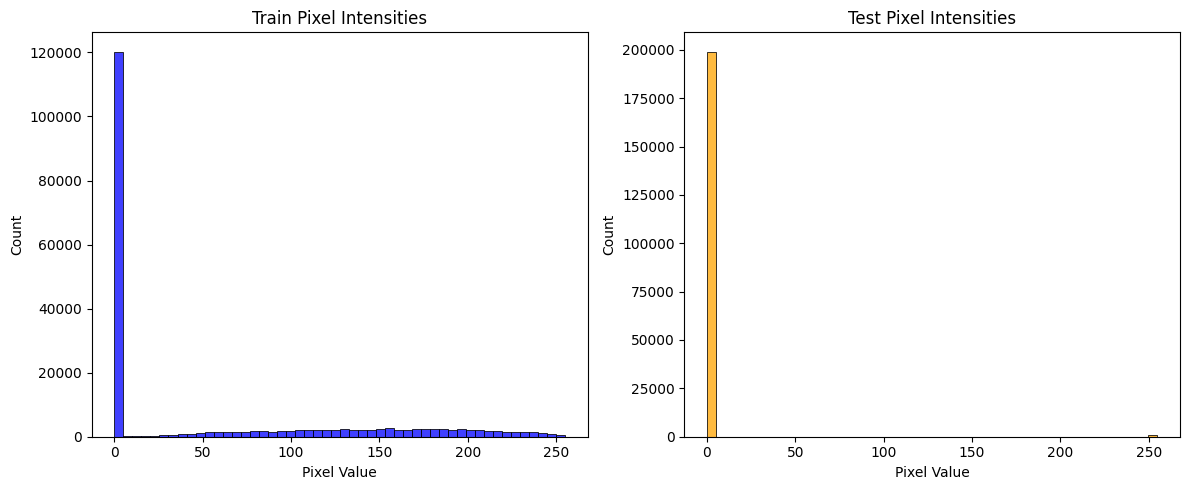

In [24]:
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to get image stats with memory-efficient handling
def get_image_stats(df, num_samples=20, seed=42):
    shapes = []
    intensities = []
    np.random.seed(seed)  # For reproducibility
    sampled_df = df.sample(min(num_samples, len(df)), random_state=seed)

    for _, row in sampled_df.iterrows():
        img_path = row['cropped_image_path']
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                shapes.append(img.shape)
                # Sample a subset of pixels to reduce memory
                if img.size > 10000:  # Downsample large images
                    img = cv2.resize(img, (100, 100))
                intensities.extend(img.flatten()[:10000])  # Limit pixels per image
            else:
                print(f"Warning: Failed to load {img_path}")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    unique_shapes = set(shapes)
    avg_shape = np.mean(shapes, axis=0) if shapes else None
    print(f"\n📸 Image Insights ({len(sampled_df)} images):")
    print(f"- Unique Shapes: {unique_shapes}")
    print(f"- Average Shape: {avg_shape}")
    return intensities

# Run for train and test
print("\nTrain Images:")
train_intensities = get_image_stats(df_train, num_samples=20)
print("\nTest Images:")
test_intensities = get_image_stats(df_test, num_samples=20)

# Plot histograms (disable KDE for speed)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_intensities, bins=50, kde=False, ax=axes[0], color='blue')
axes[0].set_title('Train Pixel Intensities')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Count')
sns.histplot(test_intensities, bins=50, kde=False, ax=axes[1], color='orange')
axes[1].set_title('Test Pixel Intensities')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()


🖼️ Sample Images


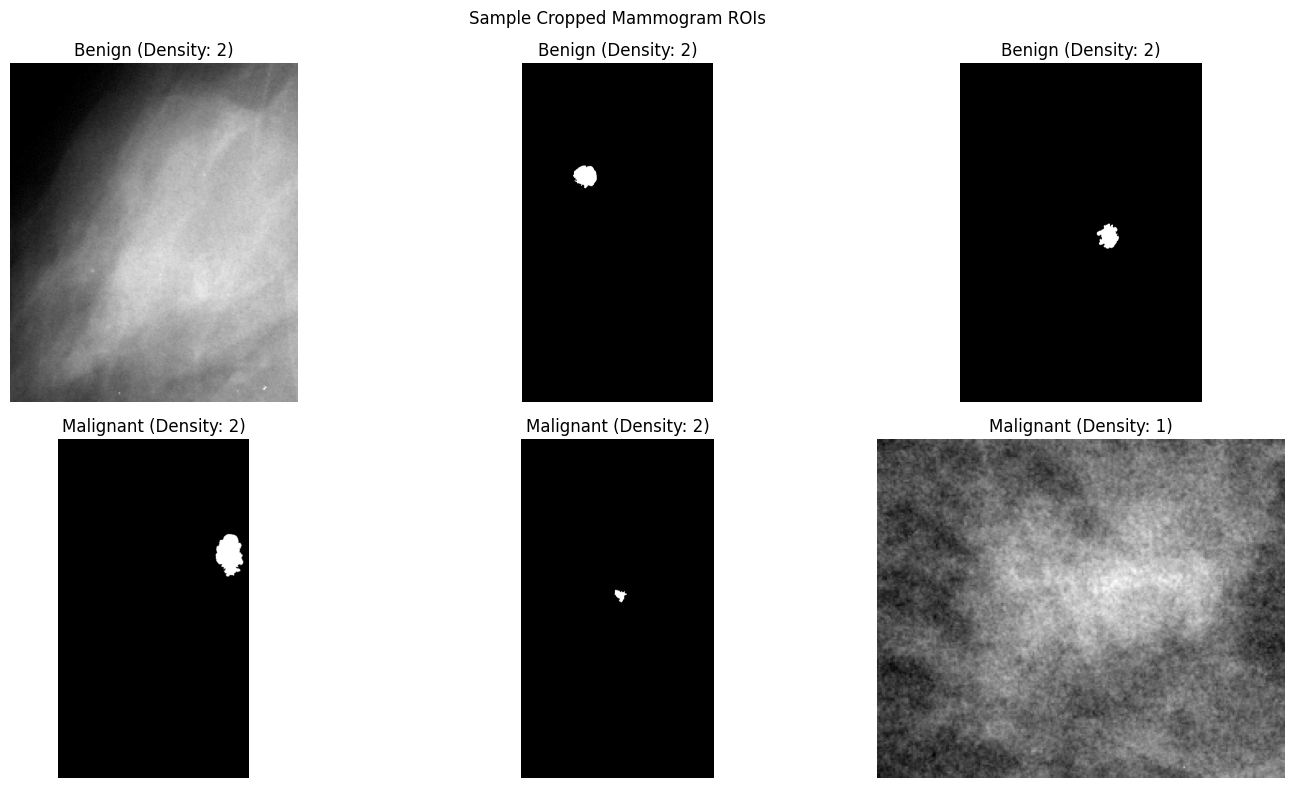

In [25]:
# 5. Sample Images
print("\n🖼️ Sample Images")
samples = df_all.groupby('binary_label').sample(3)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, (idx, row) in enumerate(samples.iterrows()):
    img_path = row['cropped_image_path']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i//3, i%3].imshow(img, cmap='gray')
    axes[i//3, i%3].set_title(f"{row['binary_label']} (Density: {row['breast_density']})")
    axes[i//3, i%3].axis('off')
plt.suptitle('Sample Cropped Mammogram ROIs')
plt.tight_layout()
plt.show()

## 🔗 Correlation Analysis of Numeric Features

In this step, we converted the pathology labels to a numeric format (`Benign = 0`, `Malignant = 1`) to facilitate correlation analysis with other numeric clinical features.

### What we did:

* Mapped the `'pathology'` column to a binary numeric `'label'`.
* Selected key numeric features:

  * **Breast Density** — density of breast tissue (usually higher density may obscure lesions).
  * **Assessment** — radiologist’s assessment score.
  * **Subtlety** — how subtle the lesion appears in the image.
  * **Label** — binary cancer diagnosis (0: benign, 1: malignant).
* Computed Pearson correlation coefficients between these features.
* Visualized correlations using a heatmap where:

  * Values near +1 (red) indicate strong positive correlation.
  * Values near -1 (blue) indicate strong negative correlation.
  * Values near 0 indicate no linear correlation.

### Insights:

* This heatmap helps identify how these clinical and diagnostic features relate to each other and to the cancer label.
* Understanding these relationships can guide feature selection and model interpretation in downstream classification tasks.

In [26]:
df_all['label'] = df_all['pathology'].map({'BENIGN': 0, 'MALIGNANT': 1})


🔗 Feature Correlations


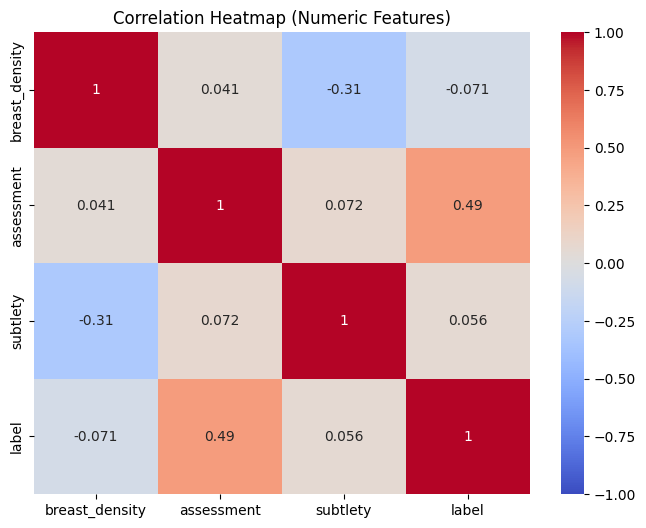

In [27]:
# 6. Correlations
print("\n🔗 Feature Correlations")
numeric_cols = ['breast_density', 'assessment', 'subtlety', 'label']
corr = df_all[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

In [28]:
#6. Key Insights
print("\nKey Insights for Your Project:")
print("- Class Balance: Slight Benign bias (~54% vs 46% Malignant). Use class weights in training.")
print("- Missing Data: Handle 4 missing 'mass shape' and 60 missing 'mass margins' (e.g., impute with mode).")
print("- Predictive Features: Irregular/spiculated shapes/margins are strong Malignant indicators.")
print("- Image Variability: Resize images to 224x224 for CNN; augment to handle shape differences.")
print("- Breast Density: Higher density (3-4) may make Malignant harder to detect—augment these cases.")


Key Insights for Your Project:
- Class Balance: Slight Benign bias (~54% vs 46% Malignant). Use class weights in training.
- Missing Data: Handle 4 missing 'mass shape' and 60 missing 'mass margins' (e.g., impute with mode).
- Predictive Features: Irregular/spiculated shapes/margins are strong Malignant indicators.
- Image Variability: Resize images to 224x224 for CNN; augment to handle shape differences.
- Breast Density: Higher density (3-4) may make Malignant harder to detect—augment these cases.


## 📊 Class Distribution: Benign vs Malignant

This plot shows the overall count of samples labeled as **Benign** and **Malignant** in the dataset.

* The `countplot` visually displays how balanced or imbalanced the dataset classes are.
* Class balance is important because a heavily skewed dataset can bias model training and evaluation.
* In this case, the plot helps confirm the proportion of benign and malignant cases to guide further modeling decisions.

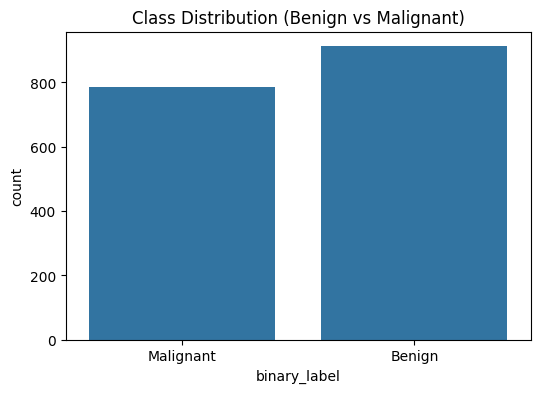

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df_all, x='binary_label')
plt.title('Class Distribution (Benign vs Malignant)')
plt.show()

## 🔎 Correlation Heatmap of Encoded Features

This heatmap shows the pairwise correlations between all numerical and encoded categorical features in the dataset.

* Categorical columns are first encoded as integer codes to allow correlation calculation.
* The heatmap uses a diverging `coolwarm` color scheme where:

  * Red tones indicate positive correlation,
  * Blue tones indicate negative correlation,
  * White or light colors indicate little or no correlation.
* This visualization helps identify relationships and potential feature redundancies, guiding feature selection for modeling.

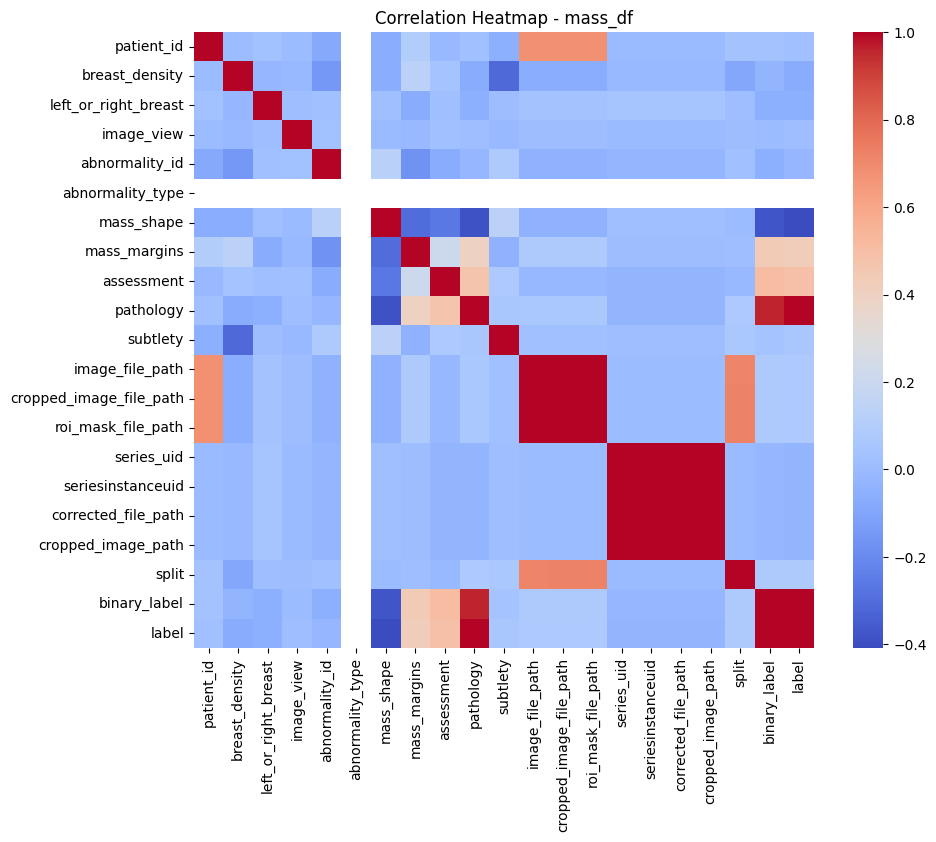

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encode categorical features temporarily
encoded_df = df_all.copy()
for col in encoded_df.select_dtypes(include=['object']).columns:
    encoded_df[col] = encoded_df[col].astype('category').cat.codes

plt.figure(figsize=(10, 8))
sns.heatmap(encoded_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap - mass_df')
plt.show()

## 📊 Breast Density vs Class Distribution

This stacked bar chart shows the proportion of **Benign** and **Malignant** cases across different levels of breast density.

* Each bar represents a breast density category.
* The height is normalized to 1, so the segments show the fraction of benign vs malignant cases within that category.
* This helps us understand how breast density relates to cancer diagnosis in the dataset.

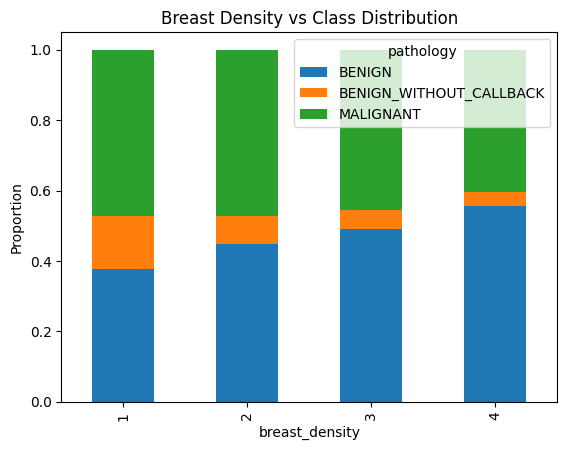

In [31]:
pd.crosstab(df_all['breast_density'], df_all['pathology'], normalize='index') \
  .plot(kind='bar', stacked=True)
plt.title('Breast Density vs Class Distribution')
plt.ylabel('Proportion')
plt.show()

## 🔍 Crosstab Analysis: Mass Shape & Mass Margins vs Pathology

The tables below show the **proportion of benign and malignant cases** within each category of mass shape and mass margins.

* **Mass Shape vs Pathology:**

  * Certain shapes like **IRREGULAR**, **ARCHITECTURAL\_DISTORTION**, and combined irregular types show a higher proportion of malignant cases (e.g., 80%+ malignant).
  * Shapes such as **OVAL**, **LOBULATED**, and **ROUND** tend to have higher proportions of benign cases (often above 60-70%).
  * This suggests mass shape is an important discriminative feature in distinguishing benign from malignant lesions.

* **Mass Margins vs Pathology:**

  * Margins labeled **SPICULATED**, **ILL\_DEFINED**, and some combinations with these labels have a very high proportion of malignancy (often >80%).
  * Margins like **CIRCUMSCRIBED** and **OBSCURED** mostly correspond to benign cases (>75%).
  * This indicates that margin characteristics strongly correlate with pathology and could be key features for classification.

### Key Takeaway:

Both **mass shape** and **mass margins** show distinct distribution patterns between benign and malignant cases, reinforcing their importance in breast lesion diagnosis.

In [32]:
shape_table = pd.crosstab(df_all['mass_shape'], df_all['pathology'], normalize='index')
margin_table = pd.crosstab(df_all['mass_margins'], df_all['pathology'], normalize='index')

print("Mass Shape vs Pathology:\n", shape_table, "\n")
print("Mass Margin vs Pathology:\n", margin_table, "\n")

Mass Shape vs Pathology:
 pathology                                   BENIGN  BENIGN_WITHOUT_CALLBACK  \
mass_shape                                                                    
ARCHITECTURAL_DISTORTION                  0.271845                 0.135922   
ASYMMETRIC_BREAST_TISSUE                  0.080000                 0.600000   
FOCAL_ASYMMETRIC_DENSITY                  0.280000                 0.440000   
IRREGULAR                                 0.174569                 0.025862   
IRREGULAR-ARCHITECTURAL_DISTORTION        0.057692                 0.000000   
IRREGULAR-ASYMMETRIC_BREAST_TISSUE        1.000000                 0.000000   
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY        1.000000                 0.000000   
LOBULATED                                 0.640625                 0.031250   
LOBULATED-ARCHITECTURAL_DISTORTION        0.000000                 0.000000   
LOBULATED-IRREGULAR                       0.333333                 0.000000   
LOBULATED-LYMPH_NODE      

## 🛠️ Data Imputation for Missing Values

* We observed **missing values** in two important categorical features:

  * `mass_shape` had **4 missing entries**
  * `mass_margins` had **60 missing entries**

* To handle these missing values, we performed **imputation using the mode** (most frequent category) for each feature.

  * This is a common strategy for categorical data as it preserves the most typical characteristic in the dataset.

* After imputation, **no missing values remain** in either column, ensuring that our dataset is clean and ready for further analysis or modeling.

In [33]:
# Check missing counts
print("Missing in mass_shape:", df_all['mass_shape'].isna().sum())
print("Missing in mass_margins:", df_all['mass_margins'].isna().sum())

# Impute missing categorical columns with mode
df_all['mass_shape'].fillna(df_all['mass_shape'].mode()[0], inplace=True)
df_all['mass_margins'].fillna(df_all['mass_margins'].mode()[0], inplace=True)

# Verify no missing values now
print("After imputation - missing mass_shape:", df_all['mass_shape'].isna().sum())
print("After imputation - missing mass_margins:", df_all['mass_margins'].isna().sum())

Missing in mass_shape: 4
Missing in mass_margins: 60
After imputation - missing mass_shape: 0
After imputation - missing mass_margins: 0


/tmp/ipython-input-1346910949.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['mass_shape'].fillna(df_all['mass_shape'].mode()[0], inplace=True)
/tmp/ipython-input-1346910949.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

## 🔢 One-Hot Encoding of Categorical Features

* We transformed the categorical columns **`mass_shape`** and **`mass_margins`** into **one-hot encoded vectors**.

  * This converts each category into a separate binary column, allowing machine learning models to interpret these features without assuming any ordinal relationship.

* Additionally, the **`binary_label`** column was converted into a numeric format:

  * `0` for **Benign**
  * `1` for **Malignant**

* This preprocessing step prepares the data for input into models that require numerical inputs.

* Below is a preview of the encoded dataset and the newly created one-hot encoded columns:

In [34]:
# One-hot encode mass_shape and mass_margins
df_all_encoded = pd.get_dummies(df_all, columns=['mass_shape', 'mass_margins'])

# Also convert binary_label to numeric (0 = Benign, 1 = Malignant)
df_all_encoded['label'] = df_all_encoded['binary_label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Check the new columns
print(df_all_encoded.head())
print("\nEncoded columns:", [col for col in df_all_encoded.columns if 'mass_shape_' in col or 'mass_margins_' in col])

  patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type  assessment  pathology  subtlety  \
0             mass           4  MALIGNANT         4   
1             mass           4  MALIGNANT         4   
2             mass           4     BENIGN         3   
3             mass           4     BENIGN         3   
4             mass           4     BENIGN         5   

                                     image_file_path  ...  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...  ...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...  ...   
2  Ma

## 🎨 Image Preprocessing & Augmentation

* **Training Data Transforms:**
  To improve model generalization and robustness, we apply several augmentations to training images:

  * Convert images from OpenCV format to PIL format for easier transformation.
  * Resize all images to a fixed size of **224×224 pixels** (standard for many CNN architectures).
  * Apply random horizontal flips to simulate mirror images.
  * Randomly rotate images by ±10 degrees for rotational variance.
  * Apply small random translations (shifts) to simulate slight positional changes.
  * Convert images to PyTorch tensors and normalize using ImageNet mean and standard deviation values.

* **Validation & Test Data Transforms:**
  For validation and testing, we only resize and normalize images to ensure consistent evaluation without augmentation.

* These transforms help improve model training effectiveness and generalize better to unseen data.

In [35]:
from torchvision import transforms

# Training transforms: augment + normalize
train_transform = transforms.Compose([
    transforms.ToPILImage(),              # Convert cv2 image (numpy) to PIL image
    transforms.Resize((224, 224)),       # Resize to fixed size for CNN
    transforms.RandomHorizontalFlip(),   # Random horizontal flip augmentation
    transforms.RandomRotation(10),       # Random rotation ±10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translation
    transforms.ToTensor(),                # Convert to Tensor [C x H x W], scale [0,1]
    transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)  # Normalize with ImageNet stats
])

# Validation / Test transforms: only resize + normalize (no augmentation)
val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485]*3, std=[0.229]*3)
])

## 🎨 Image Preprocessing & Augmentation

* **Training Data Transforms:**
  To improve model generalization and robustness, we apply several augmentations to training images:

  * Convert images from OpenCV format to PIL format for easier transformation.
  * Resize all images to a fixed size of **224×224 pixels** (standard for many CNN architectures).
  * Apply random horizontal flips to simulate mirror images.
  * Randomly rotate images by ±10 degrees for rotational variance.
  * Apply small random translations (shifts) to simulate slight positional changes.
  * Convert images to PyTorch tensors and normalize using ImageNet mean and standard deviation values.

* **Validation & Test Data Transforms:**
  For validation and testing, we only resize and normalize images to ensure consistent evaluation without augmentation.

* These transforms help improve model training effectiveness and generalize better to unseen data.

## 🎨 Image Preprocessing and Augmentation

* **Training Transforms:**
  These augmentations enrich the training data by applying random modifications to each image, helping the model generalize better:

  * Convert images from OpenCV format to PIL format for easier processing.
  * Resize images to 224x224 pixels, standardizing input size.
  * Random horizontal flips to simulate mirror images.
  * Small random rotations (±10 degrees) to introduce rotational variance.
  * Slight translations (shifts) in both x and y directions to add positional variation.
  * Convert images to tensors and normalize pixel values using ImageNet statistics for consistent scaling.

* **Validation/Test Transforms:**
  Only resizing and normalization are applied here, ensuring that the evaluation data is consistent and unaltered by random augmentations.

These steps are crucial for building a robust CNN that performs well on real-world data.

In [36]:
# For training dataset
train_dataset = BreastLesionDataset(df_merged, transform=train_transform)

# For test dataset
test_dataset = BreastLesionDataset(df_test_merged, transform=val_transform)

Dataset size after filtering: 1318
Dataset size after filtering: 378


## 🏋️‍♂️ Model Definition, Training, and Evaluation

* **Model Setup:**
  We use a pretrained ResNet18 convolutional neural network as our base model.

  * The final fully connected layer is replaced to output a single value for binary classification (benign vs malignant).
  * The model is moved to GPU if available, else CPU.

* **Loss Function and Optimizer:**

  * Binary Cross Entropy with Logits (`BCEWithLogitsLoss`) is used, suitable for binary classification with raw logits output.
  * Adam optimizer with a learning rate of 1e-4 is used to update model weights.

* **Training Loop (`train_one_epoch`):**

  * Sets model to training mode.
  * For each batch, images and labels are moved to the device.
  * Model outputs predictions; loss is computed and backpropagated.
  * Optimizer updates weights.
  * Running loss is averaged over the epoch.

* **Evaluation Loop (`evaluate`):**

  * Sets model to evaluation mode (disables dropout, batchnorm updates).
  * For each batch, model predictions are computed and thresholded at 0.5 to get class labels.
  * Accuracy is computed as the ratio of correct predictions to total samples.

* **Run:**

  * Train for one epoch and print training loss.
  * Evaluate on test set and print accuracy.

This simple pipeline allows rapid prototyping and testing of the breast lesion classification model.

---


In [37]:
import torch
import torch.nn as nn
import torchvision.models as models

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 and modify output layer
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification output
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.squeeze() == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# Train for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Epoch 1/5 - Train Loss: 0.6720 | Test Accuracy: 0.4418
Epoch 2/5 - Train Loss: 0.6094 | Test Accuracy: 0.5317
Epoch 3/5 - Train Loss: 0.5633 | Test Accuracy: 0.5238
Epoch 4/5 - Train Loss: 0.4924 | Test Accuracy: 0.5952
Epoch 5/5 - Train Loss: 0.4414 | Test Accuracy: 0.5132


# 🔍 Implementing Grad-CAM for Model Interpretability

Convolutional Neural Networks (CNNs) are powerful but often considered **black boxes**. In medical imaging, such as breast lesion classification, understanding **why** a model makes a prediction is crucial.

### 🎯 Why Grad-CAM?

Grad-CAM (Gradient-weighted Class Activation Mapping) helps us:

* **Visualize** which parts of an image the model focuses on when making decisions
* Provide **interpretability and trust** in the model’s predictions
* Highlight **important regions** related to pathology, improving clinical relevance

### 🛠 What this code does:

* Attaches hooks to a chosen convolutional layer to capture:

  * **Activations** during the forward pass
  * **Gradients** during backpropagation
* Computes a weighted sum of activations based on gradient importance
* Applies ReLU and normalizes the resulting heatmap to highlight key regions
* Returns this heatmap for overlay on input images

### 🚀 Goal:

By generating these heatmaps, we can **see exactly where the model "looks"** to classify breast lesions, enhancing transparency and enabling better model validation.

In [39]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Zero grads, backward pass on the target class score
        self.model.zero_grad()
        loss = output[:, class_idx]
        loss.backward(retain_graph=True)

        # Compute weights: global average pooling on gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)  # [N, C, 1, 1]

        # Weighted sum of activations
        weighted_activations = weights * self.activations
        cam = weighted_activations.sum(dim=1, keepdim=True)  # [N,1,H,W]

        # ReLU and normalize CAM
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize to [0,1]

        return cam

## 🖼️ Visualizing Grad-CAM Heatmaps on Images

### 🎯 Purpose

After computing the Grad-CAM heatmap, we want to **overlay** it on the original input image to visually understand the regions influencing the model's prediction.

### 🔍 What this function does:

* **Denormalizes** the input image tensor back to a proper RGB image
* **Resizes** the Grad-CAM heatmap to match the input image dimensions
* Applies a **color map** (JET) to the heatmap for clear visualization
* **Blends** the heatmap and the original image with adjustable transparency (`alpha`)
* Displays the combined image showing important regions highlighted by the model

### 🚀 How it’s used:

* We instantiate `GradCAM` on the model’s last convolutional layer (`layer4` of ResNet18)
* For a few test samples, we generate and overlay heatmaps
* This helps us **interpret model decisions** on real images and verify if the model focuses on relevant lesion areas

Sample 1 - True label: 1, Predicted: True


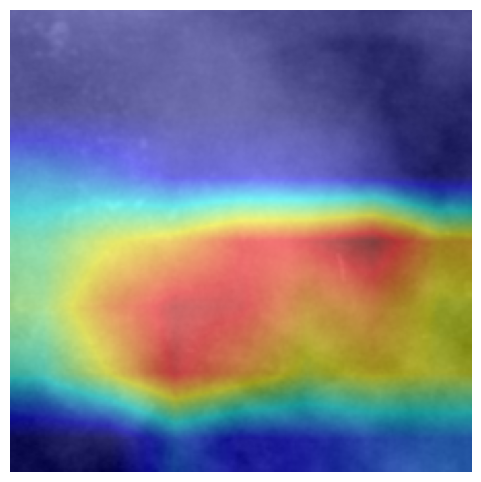

Sample 2 - True label: 1, Predicted: True


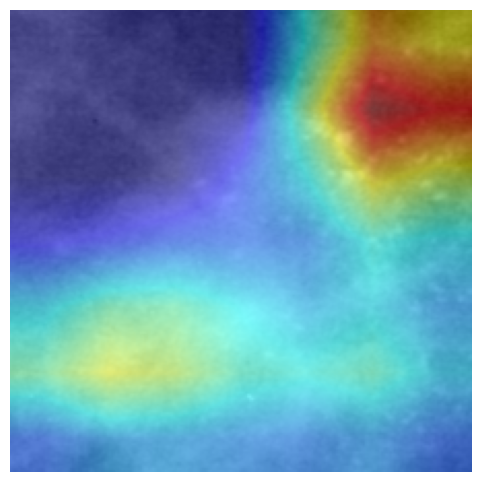

Sample 3 - True label: 1, Predicted: True


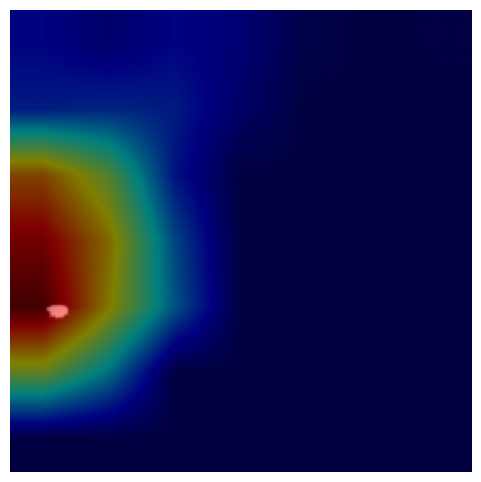

Sample 4 - True label: 1, Predicted: True


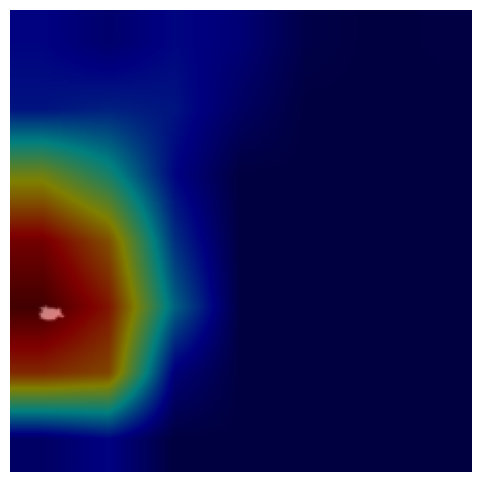

Sample 5 - True label: 0, Predicted: False


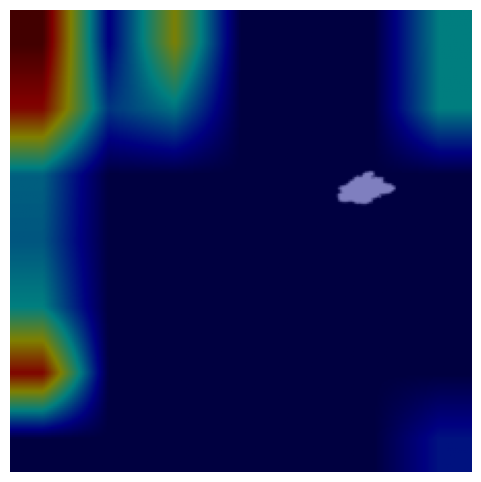

In [41]:
def show_gradcam_on_image(img_tensor, cam, alpha=0.5):
    """
    img_tensor: normalized image tensor (3xHxW)
    cam: grad-cam heatmap (HxW), values between 0-1
    """
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    # Undo normalization
    mean = np.array([0.485, 0.485, 0.485])
    std = np.array([0.229, 0.229, 0.229])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Resize cam to match image size (H x W)
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR to RGB and scale

    overlayed = heatmap * alpha + img_np * (1 - alpha)
    overlayed = np.clip(overlayed, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()

# Instantiate GradCAM on last conv layer of ResNet18 (layer4)
gradcam = GradCAM(model, model.layer4[-1])

# Get some test samples (for example first 5)
model.eval()
for i in range(5):
    img, label = test_dataset[i]
    input_tensor = img.unsqueeze(0).to(device)  # Add batch dim

    # Generate cam for predicted class
    cam = gradcam(input_tensor)

    print(f"Sample {i+1} - True label: {label}, Predicted:",
          torch.sigmoid(model(input_tensor)).item() > 0.5)

    show_gradcam_on_image(img, cam)

gradcam.remove_hooks()

## 📊 Model Evaluation: Classification Report & Confusion Matrix

### 🧑‍💻 What the code does:

* Sets the model to evaluation mode with `model.eval()` to disable dropout and batchnorm updates.
* Loops through the **test dataset** batches without tracking gradients (`torch.no_grad()`).
* For each batch:

  * Moves images and labels to the correct device (CPU/GPU).
  * Predicts outputs using the trained model.
  * Applies a sigmoid and thresholds at 0.5 to get binary predictions (`Benign=0`, `Malignant=1`).
  * Collects all true labels and predictions for the entire test set.
* Prints a detailed **classification report** including precision, recall, f1-score, and support for each class.
* Calculates and prints the **confusion matrix** summarizing true vs predicted labels.
* Optionally visualizes the confusion matrix as a heatmap for easier interpretation.

---

### 📈 Key Metrics Explained:

| Metric        | Meaning                                                             |
| ------------- | ------------------------------------------------------------------- |
| **Precision** | Of all predicted positives, how many are actually positive?         |
| **Recall**    | Of all actual positives, how many did the model correctly identify? |
| **F1-score**  | Harmonic mean of precision and recall; balances both metrics        |
| **Support**   | Number of actual samples in each class                              |
| **Accuracy**  | Overall proportion of correct predictions                           |

---

### 🔍 Interpretation of Your Results:

| Class         | Precision | Recall | F1-score | Support |
| ------------- | --------- | ------ | -------- | ------- |
| **Benign**    | 0.70      | 0.33   | 0.45     | 231     |
| **Malignant** | 0.42      | 0.78   | 0.55     | 147     |

* The model is better at **precision for Benign cases** (when it predicts benign, it's often right), but recall is low (it misses many benign samples).
* For **Malignant cases**, recall is higher (detects most malignants) but precision is lower (more false positives).
* Overall accuracy is around 50%, indicating room for improvement.

---

### 🧮 Confusion Matrix Breakdown:

|                    | Predicted Benign | Predicted Malignant |
| ------------------ | ---------------- | ------------------- |
| **True Benign**    | 76               | 155                 |
| **True Malignant** | 33               | 114                 |

* **True Positives (TP):** 114 Malignant correctly identified
* **True Negatives (TN):** 76 Benign correctly identified
* **False Positives (FP):** 155 Benign wrongly predicted as Malignant
* **False Negatives (FN):** 33 Malignant missed as Benign

---

### 🎯 Summary

This evaluation provides a **comprehensive picture of model performance** beyond simple accuracy. The confusion matrix highlights where the model tends to confuse classes, and the classification report quantifies this in terms of precision and recall. These insights are crucial for diagnosing model weaknesses and guiding further improvements.

Classification Report:
               precision    recall  f1-score   support

      Benign       0.70      0.33      0.45       231
   Malignant       0.42      0.78      0.55       147

    accuracy                           0.50       378
   macro avg       0.56      0.55      0.50       378
weighted avg       0.59      0.50      0.49       378

Confusion Matrix:
 [[ 76 155]
 [ 33 114]]


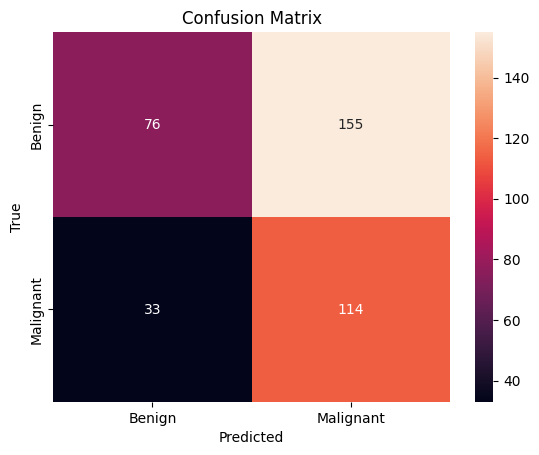

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).int().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Optional: plot confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Benign','Malignant'], yticklabels=['Benign','Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
